# Assignment 3

**Submission deadline: last lab session before or on Thursday, 02.04.2020**

**Points: 12 + 4 bonus points**

## Submission instructions
**To ease grading, please do not remove the TODO lines, put your code below them!**

The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment3_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restart and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook and paste the link into an appropriate SKOS assignment

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [0]:
%matplotlib inline

In [0]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

# Helper code

The code in this section handles data loading, result validation and plotting. 

In [0]:
def compute_error_rate(model, data_loader, device='cpu'):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)
    
    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples

def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    plt.legend()
        
    plt.subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plt.plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    plt.ylim(0, 0.20)
    plt.legend()

## Data preparation

We will download the MNIST data using `torchvision`, then use a fast in-memory loader.

In [0]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """
    __initialized = False
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [
            torch.stack(ts) for ts in zip(*batches)
        ]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [5]:
# Load the data

batch_size = 128
data_path = './data'

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    'train': InMemDataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': InMemDataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': InMemDataLoader(
        _test, batch_size=batch_size, shuffle=False)}

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


# SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs whilel solving the assignments.

In [0]:
def SGD(model, data_loaders, 
        alpha=1e-4, epsilon=0.0, decay=0.0,
        num_epochs=1, max_num_epochs=np.nan, patience_expansion=1.5,
        log_every=100, device='cpu', nesterov=True):
    
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)
    
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    #
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                print('Maximum epochs')
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #
            '''
            Typical values might be reducing the learning rate by a half 
            every 5 epochs, or by 0.1 every 20 epochs. These numbers depend 
            heavily on the type of problem and the model. 
            One heuristic you may see in practice is to watch the validation 
            error while training with a fixed learning rate, 
            and reduce the learning rate by a constant (e.g. 0.5) 
            whenever the validation error stops improving.
            '''
            if epoch % 5 == 0:
              alpha /= 2

            # if alpha < 0.0001:
            #   alpha += np.random.normal(0.001, 0.001)

            # if epoch % 20 == 0:
            #   alpha -= 0.1
                        
                        
            for x, y in data_loaders['train']:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(batch_err_rate)
                
                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if 'weight' in name:
                            #
                            # TODO: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            p.grad += 2 * decay * p
                            
                
                        #
                        # TODO: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        # alpha = TODO
                        # Done above

                        #
                        # TODO: If needed, implement here a momentum schedule
                        # epsilon = TODO
                        #

                        # NESTEROV MOMENTUM DECAY
                        # TODO: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        #
                       
                        v_prev = v[...]
                        v[...] = epsilon * v[...] - alpha * p.grad
          

                        #
                        # TODO: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        # 

                        # working on reference p
                        if nesterov:
                          p += - epsilon * v_prev + (1 + epsilon) * v[...] 
                        else:
                          p += v[...]

                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print("Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}" \
                          .format(iter_, loss.item(), batch_err_rate * 100.0, num_iter / (time.time() - tstart)))
                    tstart = time.time()
                           
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], device)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate * 100.0, num_epochs)
            print('{0}\n{1}\n{0}'.format('-' * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" %(best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

In [0]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
    
    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Please note: there are many hyperparameter settings that give the desired answer, some may require tuning all hyperparameters, some only a few.

----------------------------------------------------------
After epoch 38 | valid err rate:  1.83% | doing  38 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 25)

-------------------------------------------
Test error rate: 1.800%, training took 26s.
-------------------------------------------
CPU times: user 25.3 s, sys: 686 ms, total: 26 s
Wall time: 26.4 s


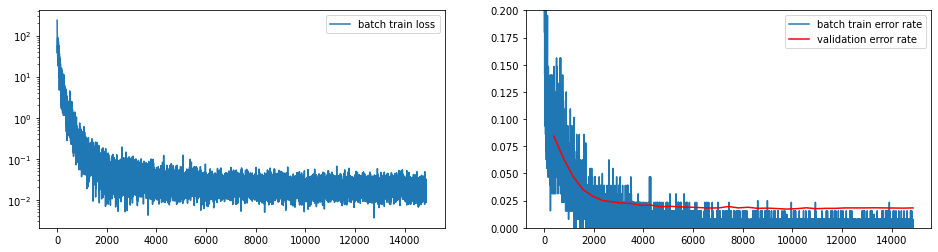

In [0]:
%%time

model = Model(
    nn.Linear(28*28, 1000),
    # nn.Tanh(),
    nn.ReLU(),
    nn.Linear(1000, 10)
    # no SoftMax here
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.5)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, max_num_epochs=50, 
    device='cuda', nesterov=True, decay=0.0005)


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")

print('{0}\n{1}\n{0}'.format('-' * len(m), m))


# Problem 3: Convolutional Network [2p]

Use convolutional and max-pooling layers (`Conv2d`, `Max_pool2d` or their functional variants) and (without dropout) get a test error rate below 1.5%.

>torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

Parameters

* in_channels (int) – Number of channels in the input image
* out_channels (int) – Number of channels produced by the convolution
* kernel_size (int or tuple) – Size of the convolving kernel
* stride (int or tuple, optional) – Stride of the convolution. (Default: 1)
* padding (int or tuple, optional) – Zero-padding added to both sides of the input (Default: 0)
* padding_mode (string, optional) – zeros
* dilation (int or tuple, optional) – Spacing between kernel elements. (Default: 1)
* groups (int, optional) – Number of blocked connections from input to output channels. (Default: 1)
* bias (bool, optional) – If True, adds a learnable bias to the output (Default: True)


So the in_channels in the beginning is 3 for images with 3 channels (colored images). For images black and white it should be 1. Some satellite images should have 4.


[Convolution animation](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        h1 = 16
        h2 = 32
        kernel = (5, 5)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=h1, kernel_size=kernel,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=h1, out_channels=h2, kernel_size=kernel,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
            )
        self.linear = nn.Sequential(
            nn.Linear(h2*kernel[0]*kernel[1], 500),
            nn.ReLU(),
            nn.Linear(500, 10)
            )

    def forward(self, X):
        out = self.conv(X)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

----------------------------------------------------------
After epoch 46 | valid err rate:  0.79% | doing  46 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 30)

-------------------------------------------
Test error rate: 0.830%, training took 71s.
-------------------------------------------
CPU times: user 1min 4s, sys: 5.71 s, total: 1min 10s
Wall time: 1min 11s


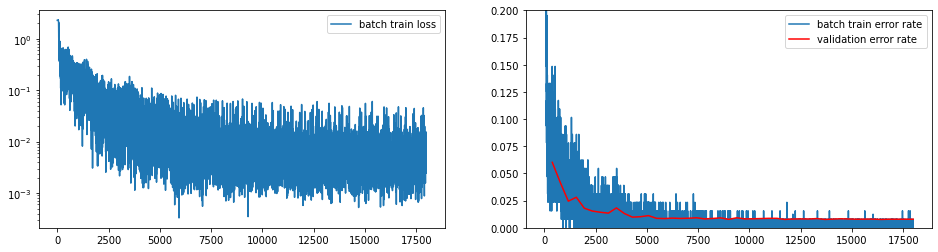

In [0]:
%%time

model = ConvNet()

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.01)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.02, epsilon=0.99, max_num_epochs=50, 
    device='cuda', nesterov=True, decay=0.0005)


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")

print('{0}\n{1}\n{0}'.format('-' * len(m), m))


torch.Size([128, 1, 28, 28])
torch.Size([128])
(28, 28)


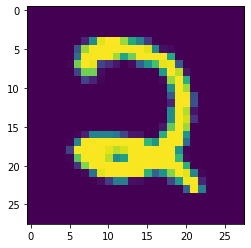

In [0]:
for x, y in mnist_loaders['train']:
  print(x.shape)
  print(y.shape)

  tmp = x[0].cpu().numpy()
  tmp = tmp.squeeze()
  print(tmp.shape)
  plt.imshow(tmp)
  break

# Problem 4: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer 
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

-----------------------------------------------------------
After epoch 100 | valid err rate:  1.46% | doing 143 epochs
-----------------------------------------------------------
Maximum epochs

Loading best params on validation set (epoch 71)

--------------------------------------------
Test error rate: 1.490%, training took 128s.
--------------------------------------------
CPU times: user 1min 54s, sys: 11.6 s, total: 2min 5s
Wall time: 2min 8s


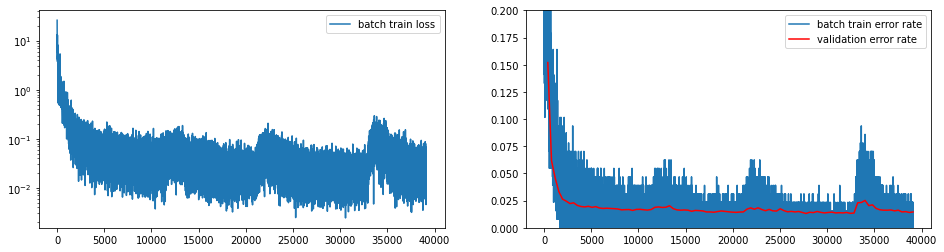

In [0]:
%%time

model = Model(
    nn.Linear(28*28, 2000),
    nn.Dropout(0.5), # % 20% dropout
    nn.ReLU(),
    nn.Linear(2000, 1000),
    nn.Dropout(0.2), # % 20% dropout
    nn.ReLU(),
    nn.Linear(1000, 10)
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            # p.normal_(0, 0.01)
            nn.init.kaiming_normal_(p, mode='fan_out')  # let's try out kaiming 
                                                        # initialization
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.005, epsilon=0.99, patience_expansion=2.0,
    max_num_epochs=100, device='cuda', nesterov=True, decay=0.0005)


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")

print('{0}\n{1}\n{0}'.format('-' * len(m), m))


# Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transfromations during training, use a data loader that re-computes them for each training minibatch. The `InMemoryDataloader` assumes that the transformations are deterministic and applies them only once.

# 5.0 Data Augmentation Playground

In [0]:
mean, std = 0.13101533792088266, 0.3085401559245608

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5,],[0.5,])])

transform2 = transforms.Compose([transforms.RandomResizedCrop(28),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5,],[0.5,])])

transform3 = transforms.Compose([transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[mean],std=[std])
                                      ])

In [0]:
fashion_mnist = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                  download=True, transform=transform)

fashion_mnist2 = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                  download=True, transform=transform2)

fashion_mnist3 = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                  download=True, transform=transform3)

loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=64, shuffle=True)
loader2 = torch.utils.data.DataLoader(fashion_mnist2, batch_size=64, shuffle=True)
loader3 = torch.utils.data.DataLoader(fashion_mnist3, batch_size=64, shuffle=True)

In [0]:
def show_transformed(images):
  grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
  plt.figure(figsize = (18, 18))  
  plt.imshow(np.transpose(grid, (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


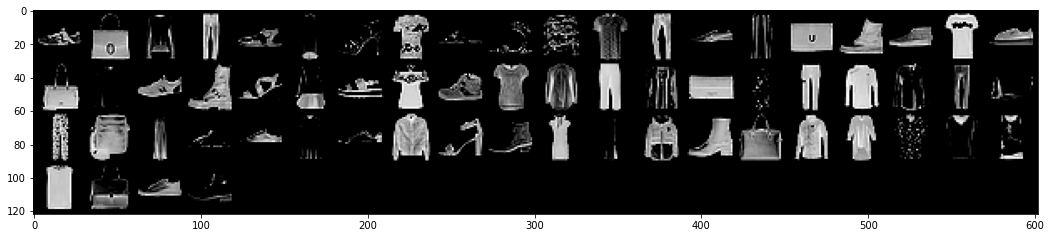

In [0]:
show_transformed(list(loader)[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


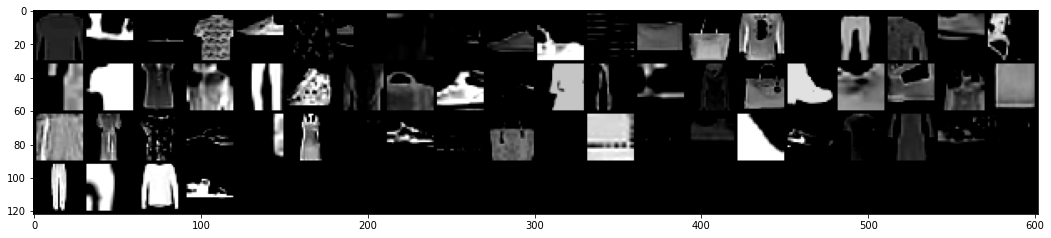

In [0]:
show_transformed(list(loader2)[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


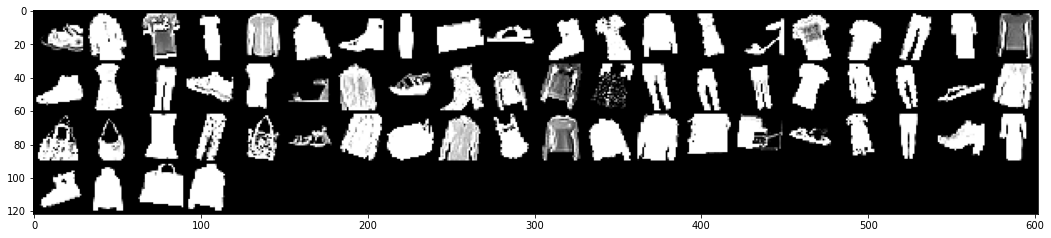

In [0]:
show_transformed(list(loader3)[0][0])

# 5.1 Apply on MNIST

In [0]:
%%time
# Load the data
batch_size = 128
data_path = './data'

transform_train = transforms.Compose([transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[mean],std=[std])
                                      ])

transform_val = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                transforms.Normalize(mean=[mean],std=[std])
                                                ])


_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform_val)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform_train)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform_val)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders_augmented = {
    'train': InMemDataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': InMemDataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': InMemDataLoader(
        _test, batch_size=batch_size, shuffle=False)}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()



CPU times: user 23 s, sys: 322 ms, total: 23.3 s
Wall time: 23.3 s


----------------------------------------------------------
After epoch 41 | valid err rate:  0.75% | doing  41 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 27)

-------------------------------------------
Test error rate: 0.720%, training took 66s.
-------------------------------------------
CPU times: user 59.7 s, sys: 5.01 s, total: 1min 4s
Wall time: 1min 5s


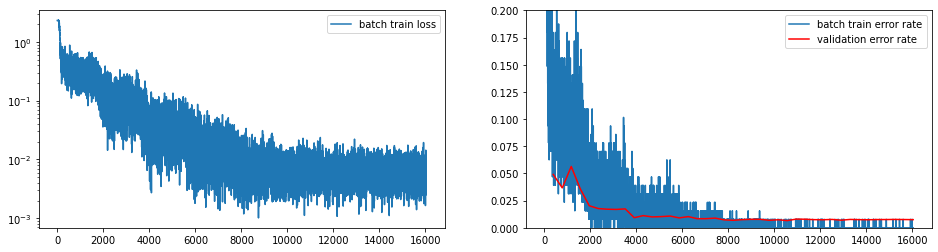

In [0]:
%%time

model = ConvNet()

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.01)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders_augmented, alpha=0.02, epsilon=0.99, max_num_epochs=50, 
    device='cuda', nesterov=True, decay=0.0005)


test_err_rate = compute_error_rate(model, mnist_loaders_augmented['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")

print('{0}\n{1}\n{0}'.format('-' * len(m), m))


# 5.2 Non deterministic dataloader (Significant improvement)
Previously I transformed data once using in memory MNIST loader and it was deterministic. <br>
Now using dataloader let's try to make every batch random.

In [0]:
mnist_dataloader = {
    'train': DataLoader(
        _train, batch_size=batch_size, shuffle=True, num_workers=4),
    'valid': DataLoader(
        _valid, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(
        _test, batch_size=batch_size, shuffle=False, num_workers=4)
    }

----------------------------------------------------------
After epoch 50 | valid err rate:  0.60% | doing  56 epochs
----------------------------------------------------------
Maximum epochs

Loading best params on validation set (epoch 37)

--------------------------------------------
Test error rate: 0.530%, training took 789s.
--------------------------------------------
CPU times: user 1min 53s, sys: 21.7 s, total: 2min 14s
Wall time: 13min 8s


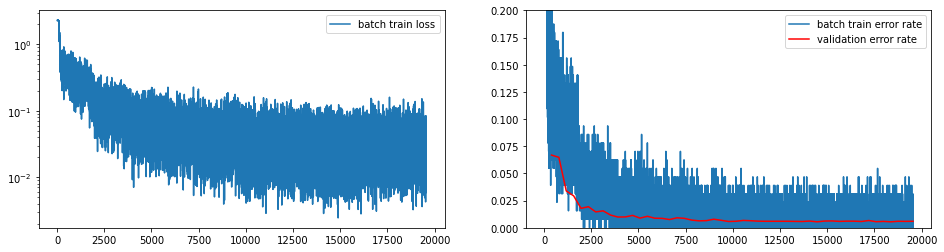

In [0]:
%%time

model = ConvNet()

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.01)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_dataloader, alpha=0.02, epsilon=0.99, max_num_epochs=50, 
    device='cuda', nesterov=True, decay=0.0005)


test_err_rate = compute_error_rate(model, mnist_dataloader['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")

print('{0}\n{1}\n{0}'.format('-' * len(m), m))


# Problem 6: Batch Normalization [1p bonus]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

https://www.coursera.org/learn/deep-neural-network/lecture/4ptp2/normalizing-activations-in-a-network

1. Normalize output of a layer before or after activation function?
  - usually before

2. Why can't I use Kaiming weights initialization?
  - 'mode=fan_out' preserves the magnitudes in the backwards pass.
  - so we could change them in forward pass ??
  - how does it work ... 

3. On test use exponentially weighted average of $\mu$ and $\sigma$ calculated from the training set

\begin{align}
  &  z_1, ... , z_m \\
  \mu & = \frac{1}{m} * \sum_{i}{z_i} \\
  {\sigma^2} & = \frac{1}{m} * \sum_{i}{(z_i - \mu)^2} \\
  z_{i}{norm} & = \frac{z_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \\
  z_{i}{hat} & = \gamma * z_{i}{norm}  + \beta \\
\end{align}


 $ {\gamma} $  and  $ {\beta} $ are learnable parameters <br>
 If  $ {\gamma} = {\sqrt{\sigma^2 + \epsilon}}  $  and  $ {\beta} = \mu $, then $ z_{i}{hat} = z_i $


### 6.1 Batch Norm vs Dropout

1. Dropout: 1.46% / 1.49%
2. Batch Norm: 1.33% / 1.41%

----------------------------------------------------------
After epoch 47 | valid err rate:  1.33% | doing  47 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 23)

-------------------------------------------
Test error rate: 1.410%, training took 56s.
-------------------------------------------
CPU times: user 53.5 s, sys: 1.87 s, total: 55.4 s
Wall time: 56 s


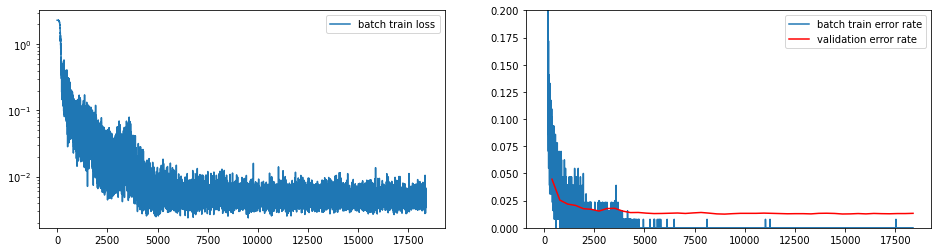

In [0]:
%%time

model = Model(
    nn.Linear(28*28, 2000),
    nn.BatchNorm1d(num_features=2000),
    nn.ReLU(),
    nn.Linear(2000, 1000),
    nn.BatchNorm1d(num_features=1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.01)
            # nn.init.kaiming_normal_(p, mode='fan_in')  # cannot use kaiming here
                                                         # Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                                                         # Why ???
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.005, epsilon=0.99, patience_expansion=2.0,
    max_num_epochs=100, device='cuda', nesterov=True, decay=0.0005)


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")

print('{0}\n{1}\n{0}'.format('-' * len(m), m))


### 6.2 Batch Norm vs CNN
1. CNN  ---> 0.79% / 0.83%
2. CNN + BN ---> 0.56% / 0.6%

In [0]:
class ConvNetBN(nn.Module):
    def __init__(self):
        super(ConvNetBN, self).__init__()
        h1 = 16
        h2 = 32
        kernel = (5, 5)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=h1, kernel_size=kernel,
                      stride=1, padding=1),
            # nn.BatchNorm2d(num_features=h1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=h1, out_channels=h2, kernel_size=kernel,
                      stride=1, padding=1),
            nn.BatchNorm2d(num_features=h2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
            )
        self.linear = nn.Sequential(
            nn.Linear(h2*kernel[0]*kernel[1], 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 10)
            )

    def forward(self, X):
        out = self.conv(X)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

----------------------------------------------------------
After epoch 49 | valid err rate:  0.56% | doing  49 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 32)

-------------------------------------------
Test error rate: 0.600%, training took 87s.
-------------------------------------------
CPU times: user 1min 19s, sys: 6.86 s, total: 1min 26s
Wall time: 1min 26s


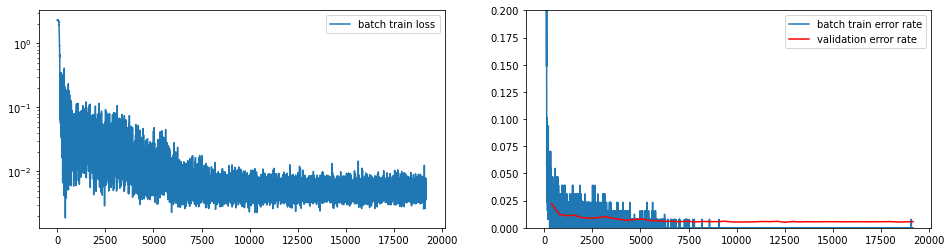

In [10]:
%%time

model = ConvNetBN()

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.01)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, max_num_epochs=50, 
    device='cuda', nesterov=True, decay=0.0005)


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")

print('{0}\n{1}\n{0}'.format('-' * len(m), m))

# Problem 7: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 8: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

# Problem 9: Hyperparameter tuner [1p bonus]

Implement a hyper-parameter tuner able to optimize the learing rate schedule, number of neurons and similar hyperparameters. For start, use random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

# Problem 10: Other tricks [1-many bonus pounts]

The neural network literature is ful of trickss for training neural networks. Find some and implement them. Please note: the number of points depends on the hardness of the extension you want to implement. If in doubt, consult the TA beforehand